In [101]:
import cv2 as cv
from glob import glob
import os
import numpy as np
from utils.poincare import calculate_singularities
from utils.segmentation import create_segmented_and_variance_images
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils import orientation
from utils.crossing_number import calculate_minutiaes
from tqdm import tqdm
from utils.skeletonize import skeletonize

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def fingerprint_pipline(input_img):
    block_size = 16

    # pipe line picture re https://www.cse.iitk.ac.in/users/biometrics/pages/111.JPG
    # normalization -> orientation -> frequency -> mask -> filtering

    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(input_img.copy(), float(100), float(100))

    # color threshold
    # threshold_img = normalized_img
    # _, threshold_im = cv.threshold(normalized_img,127,255,cv.THRESH_OTSU)
    # cv.imshow('color_threshold', normalized_img); cv.waitKeyEx()

    # ROI and normalisation
    (segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, block_size, 0.2)

    # orientations
    angles = orientation.calculate_angles(normalized_img, W=block_size, smoth=False)
    orientation_img = orientation.visualize_angles(segmented_img, mask, angles, W=block_size)
    
    # find the overall frequency of ridges in Wavelet Domain
    freq = ridge_freq(normim, mask, angles, block_size, kernel_size=5, minWaveLength=5, maxWaveLength=15)

    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq)

    # thinning oor skeletonize
    thin_image = skeletonize(gabor_img)

    # minutias
    minutias, end, bif = calculate_minutiaes(thin_image)

    # singularities
    singularities_img, FingerType = calculate_singularities(thin_image, angles, 1, block_size, mask)

    # visualize pipeline stage by stage
#     output_imgs = [input_img, normalized_img, segmented_img, orientation_img, gabor_img, thin_image, minutias, singularities_img]
    output_imgs = [input_img, minutias, singularities_img]
    
#     for i in range(len(output_imgs)): # Lặp qua từng ảnh output
#         if len(output_imgs[i].shape) == 2: # Nếu ảnh thứ i trong output là ảnh Gray(có 2 chiều)
#             output_imgs[i] = cv.cvtColor(output_imgs[i], cv.COLOR_GRAY2RGB) # Chuyển thành ảnh RGB để concatenate với 2 ảnh cuối
    
    # Chuyển list các ảnh thành ảnh 4x4
#     results = np.concatenate([np.concatenate(output_imgs[:4], 1), np.concatenate(output_imgs[4:], 1)]).astype(np.uint8)

#     return results
    return output_imgs, end, bif, FingerType

In [3]:
# open images
img_dir = './sample_inputs/*'
output_dir = './output/'
def open_images(directory):
    images_paths = glob(directory)
    images_names = [i.split('/')[-1][:-4] for i in images_paths]
    return images_names, np.array([cv.imread(img_path,0) for img_path in images_paths])

names, images = open_images(img_dir)
# image pipeline
os.makedirs(output_dir, exist_ok=True)

# for i, img in enumerate(tqdm(images)):
#     results = fingerprint_pipline(img)
    
# #     cv.imwrite(output_dir+str(i)+'.png', results)
# #     cv.imwrite(output_dir+names[i]+'.png', results)
#     cv.imshow('image pipeline', results); cv.waitKeyEx()
#     break
    
# results, end, bif, fingertype = fingerprint_pipline(images[7])
# for img in results:
#     cv.imshow('image pipeline', img)
#     cv.waitKeyEx()
#     cv.destroyAllWindows()

# Preprocessing before Mathching

In [4]:
results1, end1, bif1, fingertype1 = fingerprint_pipline(images[0])
results2, end2, bif2, fingertype2 = fingerprint_pipline(images[1])

In [5]:
count = 0
for img in results2:
#     cv.imshow('image pipeline', img)
    cv.imwrite('2-{}.jpg'.format(count), img)
    count += 1
#     cv.waitKeyEx()
#     cv.destroyAllWindows()
    
# for img in results2:
#     cv.imshow('image pipeline', img)
#     cv.waitKeyEx()
#     cv.destroyAllWindows()

In [8]:
# ending points of fingerprint 1
x_end_1 = np.array(end1)[:, 1]
y_end_1 = np.array(end1)[:, 2]

In [9]:
# ending points of fingerprint 2
x_end_2 = np.array(end2)[:, 1]
y_end_2 = np.array(end2)[:, 2]

In [10]:
# bifucation points of fingerprint 1
x_bif_1 = np.array(bif1)[:, 1]
y_bif_1 = np.array(bif1)[:, 2]

In [11]:
# bifucation points of fingerprint 2
x_bif_2 = np.array(end2)[:, 1]
y_bif_2 = np.array(end2)[:, 2]

In [12]:
center_point1 = np.array(fingertype1)[:,1:].astype(int).mean(axis=0)
y1_center_point, x1_center_point = center_point1[0], center_point1[1]

center_point2 = np.array(fingertype2)[:,1:].astype(int).mean(axis=0)
y2_center_point, x2_center_point = center_point2[0], center_point2[1]

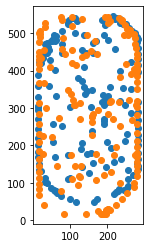

In [15]:
plt.scatter(x_end_1, y_end_1)
plt.scatter(x_end_2, y_end_2)
# plt.title('Minutiaes of 2 fingerprint image')
plt.axis('scaled')
plt.savefig('match1.jpg')

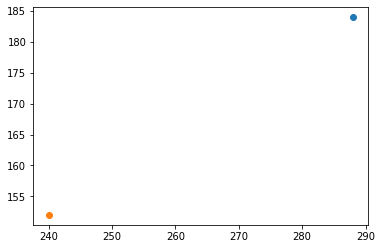

In [16]:
plt.scatter(x1_center_point, y1_center_point)
plt.scatter(x2_center_point, y2_center_point)

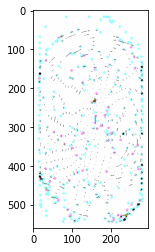

In [17]:
plt.imshow(results1[1] + results2[1])

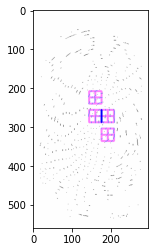

In [14]:
plt.imshow(results1[2] + results2[2])

In [18]:
x_translation = x2_center_point - x1_center_point
y_translation = y2_center_point - y1_center_point

In [19]:
# ending points of fingerprint 1
end_1 = np.array(end1)[:,1:]
end_2 = np.array(end2)[:,1:]

In [20]:
# bifucation points of fingerprint 1
bif_1 = np.array(bif1)[:,1:]
bif_2 = np.array(bif2)[:,1:]

In [21]:
translation_vecotr = np.array([x_translation, y_translation])

In [22]:
translation_vecotr

array([-48., -32.])

In [23]:
new_end_1 = end_1 + translation_vecotr
new_bif_1 = bif_1 + translation_vecotr

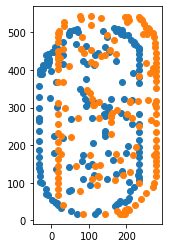

In [24]:
plt.scatter(new_end_1[:, 0], new_end_1[:, 1])
plt.scatter(end_2[:, 0], end_2[:, 1])
# plt.title('Minutiaes of 2 fingerprint image')
plt.axis('scaled')
plt.savefig('match2.jpg')

(-47.15, 286.15, 20.299999999999997, 563.7)

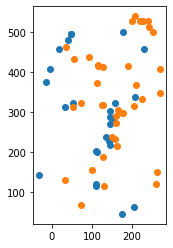

In [22]:
plt.scatter(new_bif_1[:, 0], new_bif_1[:, 1])
plt.scatter(bif_2[:, 0], bif_2[:, 1])
plt.axis('scaled')

In [23]:
"Center Point of finger1: ({}, {})".format(x1_center_point, y1_center_point)

'Center Point of finger1: (288.0, 184.0)'

In [24]:
"Center Point of finger2: ({}, {})".format(x2_center_point, y2_center_point)

'Center Point of finger2: (240.0, 152.0)'

In [25]:
"Center Point of finger1 moved: ({}, {})".format(x1_center_point + translation_vecotr[0], y1_center_point + translation_vecotr[1])

'Center Point of finger1 moved: (240.0, 152.0)'

# Matching

In [33]:
import cv2 as cv
from glob import glob
import os
import numpy as np
from utils.poincare import calculate_singularities
from utils.segmentation import create_segmented_and_variance_images
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils import orientation
from utils.crossing_number import calculate_minutiaes
from utils.skeletonize import skeletonize

from MyMAS import MAS

In [2]:
def fingerprint_pipline(input_img):
    block_size = 16

    # pipe line picture re https://www.cse.iitk.ac.in/users/biometrics/pages/111.JPG
    # normalization -> orientation -> frequency -> mask -> filtering

    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(input_img.copy(), float(100), float(100))

    # color threshold
    # threshold_img = normalized_img
    # _, threshold_im = cv.threshold(normalized_img,127,255,cv.THRESH_OTSU)
    # cv.imshow('color_threshold', normalized_img); cv.waitKeyEx()

    # ROI and normalisation
    (segmented_img, normim, mask) = create_segmented_and_variance_images(normalized_img, block_size, 0.2)

    # orientations
    angles = orientation.calculate_angles(normalized_img, W=block_size, smoth=False)
    orientation_img = orientation.visualize_angles(segmented_img, mask, angles, W=block_size)
    
    # find the overall frequency of ridges in Wavelet Domain
    freq = ridge_freq(normim, mask, angles, block_size, kernel_size=5, minWaveLength=5, maxWaveLength=15)

    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq)

    # thinning oor skeletonize
    thin_image = skeletonize(gabor_img)

    # minutias
    minutias, end, bif = calculate_minutiaes(thin_image)

    # singularities
    singularities_img, FingerType = calculate_singularities(thin_image, angles, 1, block_size, mask)

    # visualize pipeline stage by stage
#     output_imgs = [input_img, normalized_img, segmented_img, orientation_img, gabor_img, thin_image, minutias, singularities_img]
    output_imgs = [input_img, minutias, singularities_img]
    
#     for i in range(len(output_imgs)): # Lặp qua từng ảnh output
#         if len(output_imgs[i].shape) == 2: # Nếu ảnh thứ i trong output là ảnh Gray(có 2 chiều)
#             output_imgs[i] = cv.cvtColor(output_imgs[i], cv.COLOR_GRAY2RGB) # Chuyển thành ảnh RGB để concatenate với 2 ảnh cuối
    
    # Chuyển list các ảnh thành ảnh 4x4
#     results = np.concatenate([np.concatenate(output_imgs[:4], 1), np.concatenate(output_imgs[4:], 1)]).astype(np.uint8)

#     return results
    return output_imgs, end, bif, FingerType

In [5]:
def DISTANCE(U, V) -> float:
    """
    """
    return np.sqrt((U[0] - V[0])**2 + (U[1] - V[1])**2)

In [6]:
def Points_distance(points1, points2) -> list:
    n = points1.shape[0]
    m = points2.shape[0]
    Distance = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            Distance[i, j] = DISTANCE(points1[i], points2[j])
    return Distance

In [7]:
def Filter_Points(ListPoints, CenterPoint, size = (0,0)):
    """
    """
    n = ListPoints.shape[0]
    ResultPoints = []
    for i in range(n):
        distance = np.abs(CenterPoint - ListPoints[i])
        if (distance[0] <= size[0]/2) and (distance[1] <= size[1]/2):
            ResultPoints.append(ListPoints[i].tolist())
    return np.array(ResultPoints)

In [8]:
def Transtation_Finger(Minutiae, Trans_Vector) -> np.ndarray:
    """
    """
    return Minutiae + Trans_Vector

In [9]:
def MATCH(finger1, finger2, alpha=0.5, box_size=(0, 0)) -> bool:
    """
    """
    # Get feature
    center_point1, end_1, bif_1 = finger1[0], finger1[1], finger1[2]
    center_point2, end_2, bif_2 = finger2[0], finger2[1], finger2[2]
    
    translation_vector = center_point2 - center_point1
    
    # Translation minutiaes
    end_1 = Transtation_Finger(end_1, translation_vector)
    bif_1 = Transtation_Finger(bif_1, translation_vector)
    
    # Filter minutiaes
    new_end_1 = Filter_Points(end_1, center_point2, size=box_size)
    new_bif_1 = Filter_Points(bif_1, center_point2, size=box_size)
    new_end_2 = Filter_Points(end_2, center_point2, size=box_size)
    new_bif_2 = Filter_Points(bif_2, center_point2, size=box_size)
    
    n1_end = new_end_1.shape[0]
    n1_bif = new_bif_1.shape[0]
    n2_end = new_end_2.shape[0]
    n2_bif = new_bif_2.shape[0]
    
    # Match ending points
    Distance_end = Points_distance(new_end_1, new_end_2)
    end_min_dist = Distance_end.min(axis=0)
    end_min_index = Distance_end.argmin(axis=0)
    
    # Match bifucation points
    Distance_bif = Points_distance(new_bif_1, new_bif_2)
    bif_min_dist = Distance_bif.min(axis=0)
    bif_min_index = Distance_bif.argmin(axis=0)
    
    # Check Matching
    end_matched = np.where(end_min_dist <= 15)[0].shape[0]
    bif_matched = np.where(bif_min_dist <= 15)[0].shape[0]
    
    if (end_matched + bif_matched)/(n1_end + n1_bif) >= alpha:
        return True
    else:
        return False

In [10]:
box_size = (150, 300)

In [75]:
# MATCH(images[0], images[2], box_size=(150, 300))

In [11]:
def Draw_Result():
    """
    """
    pass

In [12]:
def FeaturesExtraction(finger):
    """
    """
    imgresult, end, bif, fingertype = fingerprint_pipline(finger)
    center_point = np.array(fingertype)[:,1:].astype(int).mean(axis=0)
    
    end = np.array(end)[:,1:]
    bif = np.array(bif)[:,1:]
    
    return [center_point, end, bif]

In [74]:
# finger1 = FeaturesExtraction(images[0])
# finger2 = FeaturesExtraction(images[3])

In [72]:
# MATCH(finger1, finger2, box_size=(150,300))

In [13]:
def S_Generation(PIN, lenMask) -> str:
    """
    """
    S = bin(PIN)[2:]
    n = len(S)
    k = lenMask//n
    
    return S*k + S[:lenMask - n*k]
    

In [14]:
def Features2Msg(features):
    """
    """
    center, end, bif = features[0].astype(int), features[1].astype(int), features[2].astype(int)
    
    center_msg = "{:3d}{:3d}".format(center[0], center[1]).replace(' ', '0')
    
    n = end.shape[0]
    m = bif.shape[0]
    
    end_msg = ''
    for point in end:
        end_msg += "{:3}{:3}".format(point[0], point[1]).replace(' ', '0')
    
    bif_msg = ''
    for point in bif:
        bif_msg += "{:3}{:3}".format(point[0], point[1]).replace(' ', '0')
    
    return "{}{:3}{:3}{}{}".format(center_msg, n, m, end_msg, bif_msg).replace(' ', '0')
    

In [161]:
#Features2Msg(finger1)

In [15]:
def EncryptFinger(finger, PIN, A, B, X, Code, lenMask, k, padWord):
    """
    """
    # generation S
#     S = S_Generation(PIN, lenMask)
    S = b'10001101101011101000100011011010111010001110100011101000'
    print('generation Mask successful!')
    
    Msg = Features2Msg(finger)
    print('generation Msg successful!')
    
    cryptosystem = MAS(A, B, Code, X, S, k, padWord)
    
    EMsg = cryptosystem.Encode(Msg)
    print('Encode successful!')
    
    return EMsg

In [93]:
def Emsg2Features(EMsg, PIN, A, B, X, Code, lenMask, k, padWord):
    """
    """
    end = []
    bif = []
    
    S = b'10001101101011101000100011011010111010001110100011101000'
    print('generation Mask successful!')
    
    cryptosystem = MAS(A, B, Code, X, S, k, padWord)
    
    Result =  "".join(cryptosystem.Decode(EMsg))
    
    CenterPoint = np.array([Result[:3], Result[3:6]]).astype(int)
    n, m = int(Result[6:9]), int(Result[9: 12])
    
    t = 12
    for i in range(n):
        end.append([int(Result[t: t+3]), int(Result[t+3: t+6])])
        t += 6
    for i in range(m):
        bif.append([int(Result[t: t+3]), int(Result[t+3: t+6])])
        t += 6
    return [np.array(CenterPoint), np.array(end), np.array(bif)]

In [112]:
# PIN = 999999

# S = S_Generation(PIN, 56)
# print(S, '\n', len(S))

In [58]:
# Config Cryptosystem
PIN = 123456
lenMask = 56

# Example Initialization
A = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
B = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n','o', 'p']
Code = {'a': b'1000',
        'b': b'1110',
        'c': b'0011', 
        'd': b'1111', 
        'e': b'1101', 
        'f': b'0010', 
        'g': b'1100', 
        'h': b'0101',
        'i': b'1011',
        'j': b'0000',
        'k': b'1001',
        'l': b'0111',
        'm': b'0100',
        'n': b'1010',
        'o': b'0001',
        'p': b'0110'}

# Language
X0 = ['a', 'cgh']
X1 = ['egm', 'nmc']
X2 = ['ig', 'fce']
X3 = ['jkd']
X4 = ['bea', 'mok']
X5 = ['fno', 'ihc']
X6 = ['cei']
X7 = ['demc', 'khm']
X8 = ['lbkh']
X9 = ['kog', 'dcef']
X = [X0, X1, X2, X3, X4, X5, X6, X7, X8, X9]
paddingWord = 'p'
k = 3

In [59]:
finger = FeaturesExtraction(images[0])

In [60]:
Msg = Features2Msg(finger)

In [61]:
Msg

'184288166026015170015182015200015219015244015270015295015305015330015359015389016302018135018149018163018421018427019433022131024421025438026445027434032446034103034114034472036458038099038468039474040446041462043454044358046428050087050480052480054210054483055256057494058080059479061079061168061401062078062481063491064333066072075066078448079471080251080506095530096110096174096524098536099056100113101302108539114500115540116050119533123381130191132206132371132456133143137355139409139495141337144448145345146176151126156303157181158238160349161153161446163473164050171478173057185536187315189335190309190494191256191265192270195320195521196141198317200210202333202481208356211192214545217069219155220457221537224075225541228079231083233318234527235400235538237164240528241354241524245082246307248211251524252085252230254133255091256111259513262351263287264423267506269121269500273499279153280475280490281138281146281164281181281200281215281228281247281267281289281316281397281414281432281445281

In [62]:
EMsg = EncryptFinger(finger, PIN, A, B, X, Code, lenMask, k, paddingWord)

generation Mask successful!
generation Msg successful!
MAS cryptosystem initialization successful!
Author: Thanh HoangVan
Github: thanhhoangvan
+-----------------------------------------+
Encode successful!


In [98]:
finger_origin = Emsg2Features(EMsg, PIN, A, B, X, Code, lenMask, k, paddingWord)

generation Mask successful!
MAS cryptosystem initialization successful!
Author: Thanh HoangVan
Github: thanhhoangvan
+-----------------------------------------+


In [108]:
finger_match = FeaturesExtraction(images[7])

In [109]:
MATCH(finger_origin, finger_match, box_size=(150, 300))

False